In [1]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from acoustic_BEM.geometry import Body, Field
from acoustic_BEM.mesh import Mesh
from acoustic_BEM.elements import ContinuousP1Mesh, DiscontinuousP1Mesh
from acoustic_BEM.integrators import ElementIntegratorCollocation
from acoustic_BEM.matrix_assembly import ContinuousAssembler, DiscontinuousAssembler
from acoustic_BEM.solve import BEMSolver

%load_ext autoreload
%autoreload 2

In [2]:
def icosahedron():
    """Generate vertices and faces of a unit icosahedron."""
    t = (1.0 + np.sqrt(5.0)) / 2.0
    V = np.array([
        [-1,  t, 0], [ 1,  t, 0], [-1, -t, 0], [ 1, -t, 0],
        [ 0, -1,  t], [ 0,  1,  t], [ 0, -1, -t], [ 0,  1, -t],
        [ t,  0, -1], [ t,  0,  1], [-t,  0, -1], [-t,  0,  1],
    ], dtype=float)
    V /= np.linalg.norm(V, axis=1)[:, None]
    
    F = np.array([
        [0, 11, 5], [0, 5, 1], [0, 1, 7], [0, 7,10], [0,10,11],
        [1, 5, 9], [5,11, 4], [11,10,2], [10,7,6], [7, 1, 8],
        [3, 9, 4], [3, 4, 2], [3, 2, 6], [3, 6, 8], [3, 8, 9],
        [4, 9, 5], [2, 4,11], [6, 2,10], [8, 6, 7], [9, 8, 1]
    ], dtype=int)
    return V, F

def subdivide_sphere(V, F, levels=1):
    """Loop-subdivide each triangle and re-project to unit sphere."""
    for _ in range(levels):
        mid_cache = {}
        newF = []
        
        def midpoint(i, j):
            key = tuple(sorted((i, j)))
            if key in mid_cache:
                return mid_cache[key]
            m = (V[i] + V[j]) * 0.5
            m = m / np.linalg.norm(m)
            idx = len(V_list)
            V_list.append(m)
            mid_cache[key] = idx
            return idx
        
        V_list = [v.copy() for v in V]
        for a, b, c in F:
            ab = midpoint(a, b)
            bc = midpoint(b, c)
            ca = midpoint(c, a)
            newF += [
                [a, ab, ca], [b, bc, ab],
                [c, ca, bc], [ab, bc, ca],
            ]
        V = np.asarray(V_list)
        F = np.asarray(newF, dtype=int)
    return V, F

In [3]:
def analytic_phi_pulsating_sphere(r: np.ndarray, 
                                  a: float, 
                                  k: float, 
                                  vr: complex,
                                  rho0: float = 1.225,
                                  c0: float = 343.0) -> np.ndarray:
    """
    Analytic velocity potential for a pulsating sphere.
    
    Args:
        r: Radial distance from sphere center
        a: Sphere radius
        k: Wavenumber
        vr: Radial velocity at sphere surface
        rho0: Air density
        c0: Speed of sound
    """
    A = a/r * rho0 * c0 * vr * (1j * k * a) / (1 - 1j*k*a)
    return A * np.exp(1j*k*(r - a))

In [4]:
radius = 1  # sphere radius [m]
rho0 = 1.225    # air density [kg/m³]
c0 = 343.0      # speed of sound [m/s]
Vr = 1.0        # radial velocity [m/s]

# Mesh generation
subdiv = 2  # subdivision level (3 is good balance, 4 for finer mesh)
nodes, elements = icosahedron()
nodes, elements = subdivide_sphere(nodes, elements, levels=subdiv)
nodes *= radius

print(f"Mesh: {nodes.shape[0]} nodes, {elements.shape[0]} elements")

Mesh: 162 nodes, 320 elements


In [5]:
# Field evaluation point
field_distance = 2.0  # meters from center
field_pts = np.array([[0, 0, field_distance]])

# Frequency sweep
freq_min, freq_max, n_freq = 50, 500, 50
frequencies = np.linspace(freq_min, freq_max, n_freq)

field = Field(
    field_extent=np.array([[field_distance, field_distance+0.1],
                          [0, 0.1], [0, 0.1]]),
    num_points=np.array([1, 1, 1]),
    rho0=rho0,
    c0=c0,
)

In [6]:
results = {
    'analytic': [],
    # 'continuous': [],
    # 'continuous_bm': [],
    'discontinuous_interior': [],
    'discontinuous_interior_bm': [],
    # 'discontinuous_centroid': [],
    # 'discontinuous_centroid_bm': [],
}

for f in tqdm(frequencies, desc="Frequency sweep"):
    omega = 2 * np.pi * f
    k = omega / c0
    
    # Boundary condition (Neumann - velocity BC)
    vel_bc = np.ones(nodes.shape[0]) * Vr
    neumann_bc = vel_bc * 1j * omega * rho0
    
    # Create Body and base Mesh
    sphere = Body(
        mesh_nodes=nodes, 
        mesh_elements=elements, 
        Neumann_BC=neumann_bc,
        Dirichlet_BC=None,
        frequency=f,
    )
    
    base_mesh = Mesh(
        source_object=sphere,
        peripheral_objects=None,
        field=field
    )
    
    # Integrator (shared by all)
    integrator = ElementIntegratorCollocation(k=k)
    
    # ========================================================================
    # ANALYTIC SOLUTION
    # ========================================================================
    r = np.linalg.norm(field_pts)
    phi_analytic = analytic_phi_pulsating_sphere(r, radius, k, Vr, rho0, c0)
    results['analytic'].append(phi_analytic)
    
    # ========================================================================
    # CONTINUOUS ELEMENTS
    # ========================================================================
    # cont_mesh = ContinuousP1Mesh(base_mesh)
    # cont_assembler = ContinuousAssembler(cont_mesh, integrator, quad_order=7)
    # cont_solver = BEMSolver(cont_assembler)
    
    # # Standard formulation
    # mats_cont = {
    #     "S": cont_assembler.assemble("S", verbose=False),
    #     "D": cont_assembler.assemble("D", verbose=False),
    # }
    # phi_bnd = cont_solver.solve_direct(matrices=mats_cont, verbose=False)
    # phi_field = cont_solver.evaluate_field(field_pts, quad_order=7, verbose=False)
    # results['continuous'].append(phi_field[0])
    
    # # Burton-Miller formulation
    # mats_cont_bm = {
    #     **mats_cont,
    #     "Kp": cont_assembler.assemble("Kp", verbose=False),
    #     "NReg": cont_assembler.assemble("NReg", verbose=False),
    # }
    # phi_bnd = cont_solver.solve_burton_miller(matrices=mats_cont_bm, 
    #                                           alpha=1j/k, 
    #                                           verbose=False)
    # phi_field = cont_solver.evaluate_field(field_pts, quad_order=7, verbose=False)
    # results['continuous_bm'].append(phi_field[0])
    
    # ========================================================================
    # DISCONTINUOUS ELEMENTS - INTERIOR SHIFTED
    # ========================================================================
    disc_mesh_int = DiscontinuousP1Mesh(
        base_mesh, 
        collocation_strategy="interior_shifted",
        shift_factor=0.15
    )
    disc_assembler_int = DiscontinuousAssembler(disc_mesh_int, integrator, 
                                                quad_order=7)
    disc_solver_int = BEMSolver(disc_assembler_int)
    
    # Standard formulation
    mats_disc_int = {
        "S": disc_assembler_int.assemble("S", verbose=False),
        "D": disc_assembler_int.assemble("D", verbose=False),
    }
    phi_bnd = disc_solver_int.solve_direct(matrices=mats_disc_int, verbose=False)
    phi_field = disc_solver_int.evaluate_field(field_pts, quad_order=7, 
                                               verbose=False)
    results['discontinuous_interior'].append(phi_field[0])
    
    # Burton-Miller formulation
    mats_disc_int_bm = {
        **mats_disc_int,
        "Kp": disc_assembler_int.assemble("Kp", verbose=False),
        "NReg": disc_assembler_int.assemble("NReg", verbose=False),
    }
    phi_bnd = disc_solver_int.solve_burton_miller(matrices=mats_disc_int_bm, 
                                                  alpha=1j/k, 
                                                  verbose=False)
    phi_field = disc_solver_int.evaluate_field(field_pts, quad_order=7, 
                                               verbose=False)
    results['discontinuous_interior_bm'].append(phi_field[0])

Frequency sweep:   0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
p_analytic = np.array(results['analytic'])
# p_continuous = np.array(results['continuous'])
# p_continuous_bm = np.array(results['continuous_bm'])
p_disc_int = np.array(results['discontinuous_interior']) * -1
p_disc_int_bm = np.array(results['discontinuous_interior_bm']) * -1

# Compute wavenumbers for plotting
k_vec = 2 * np.pi * frequencies / c0

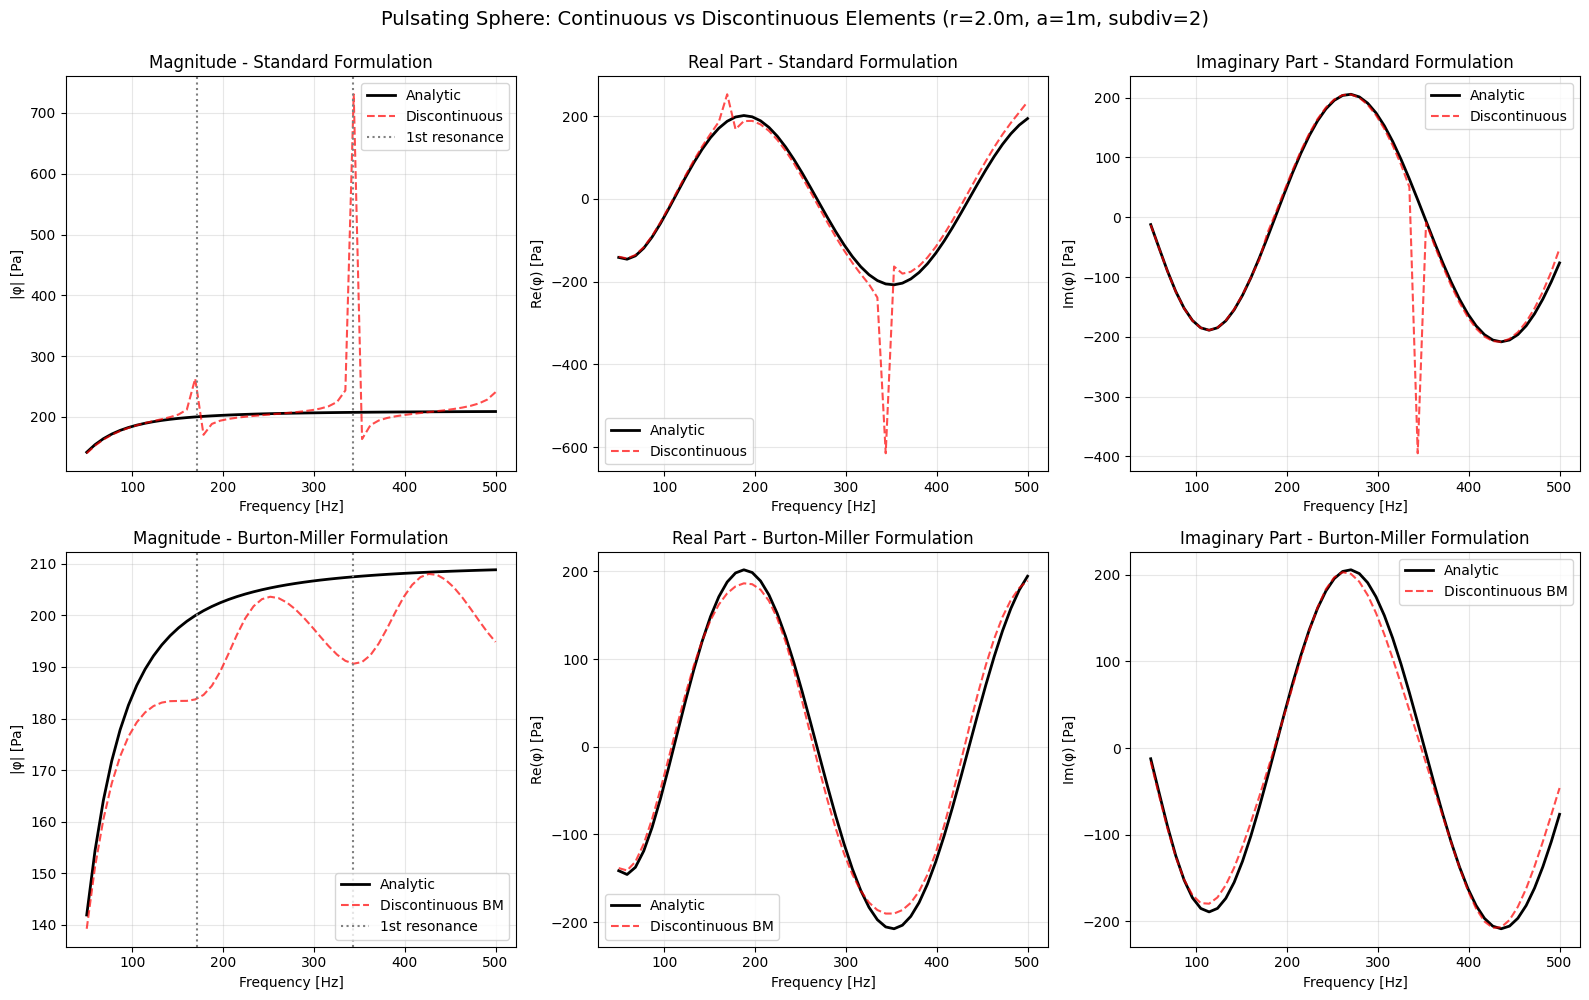

In [8]:
fig = plt.figure(figsize=(16, 10))

# Row 1: Continuous vs Discontinuous (Standard formulation)
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(frequencies, np.abs(p_analytic), 'k-', label='Analytic', linewidth=2)
# ax1.plot(frequencies, np.abs(p_continuous), 'b--', label='Continuous', alpha=0.7)
ax1.plot(frequencies, np.abs(p_disc_int), 'r--', label='Discontinuous', alpha=0.7)
ax1.axvline(x=np.pi * c0 / (2 * np.pi * radius), color='gray', 
            linestyle=':', label='1st resonance')
ax1.axvline(x=2*np.pi * c0 / (2 * np.pi * radius), color='gray', linestyle=':')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('|φ| [Pa]')
ax1.set_title('Magnitude - Standard Formulation')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(frequencies, np.real(p_analytic), 'k-', label='Analytic', linewidth=2)
# ax2.plot(frequencies, np.real(p_continuous), 'b--', label='Continuous', alpha=0.7)
ax2.plot(frequencies, np.real(p_disc_int), 'r--', label='Discontinuous', alpha=0.7)
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Re(φ) [Pa]')
ax2.set_title('Real Part - Standard Formulation')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(frequencies, np.imag(p_analytic), 'k-', label='Analytic', linewidth=2)
# ax3.plot(frequencies, np.imag(p_continuous), 'b--', label='Continuous', alpha=0.7)
ax3.plot(frequencies, np.imag(p_disc_int), 'r--', label='Discontinuous', alpha=0.7)
ax3.set_xlabel('Frequency [Hz]')
ax3.set_ylabel('Im(φ) [Pa]')
ax3.set_title('Imaginary Part - Standard Formulation')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Row 2: Continuous vs Discontinuous (Burton-Miller formulation)
ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(frequencies, np.abs(p_analytic), 'k-', label='Analytic', linewidth=2)
# ax4.plot(frequencies, np.abs(p_continuous_bm), 'b--', label='Continuous BM', alpha=0.7)
ax4.plot(frequencies, np.abs(p_disc_int_bm), 'r--', label='Discontinuous BM', alpha=0.7)
ax4.axvline(x=np.pi * c0 / (2 * np.pi * radius), color='gray', 
            linestyle=':', label='1st resonance')
ax4.axvline(x=2*np.pi * c0 / (2 * np.pi * radius), color='gray', linestyle=':')
ax4.set_xlabel('Frequency [Hz]')
ax4.set_ylabel('|φ| [Pa]')
ax4.set_title('Magnitude - Burton-Miller Formulation')
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(frequencies, np.real(p_analytic), 'k-', label='Analytic', linewidth=2)
# ax5.plot(frequencies, np.real(p_continuous_bm), 'b--', label='Continuous BM', alpha=0.7)
ax5.plot(frequencies, np.real(p_disc_int_bm), 'r--', label='Discontinuous BM', alpha=0.7)
ax5.set_xlabel('Frequency [Hz]')
ax5.set_ylabel('Re(φ) [Pa]')
ax5.set_title('Real Part - Burton-Miller Formulation')
ax5.legend()
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(2, 3, 6)
ax6.plot(frequencies, np.imag(p_analytic), 'k-', label='Analytic', linewidth=2)
# ax6.plot(frequencies, np.imag(p_continuous_bm), 'b--', label='Continuous BM', alpha=0.7)
ax6.plot(frequencies, np.imag(p_disc_int_bm), 'r--', label='Discontinuous BM', alpha=0.7)
ax6.set_xlabel('Frequency [Hz]')
ax6.set_ylabel('Im(φ) [Pa]')
ax6.set_title('Imaginary Part - Burton-Miller Formulation')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.suptitle(f'Pulsating Sphere: Continuous vs Discontinuous Elements '
             f'(r={field_distance}m, a={radius}m, subdiv={subdiv})', 
             fontsize=14, y=0.995)
plt.tight_layout()
plt.show()


In [ ]:
err_cont = np.abs(p_continuous - p_analytic) / np.abs(p_analytic)
err_cont_bm = np.abs(p_continuous_bm - p_analytic) / np.abs(p_analytic)
err_disc_int = np.abs(p_disc_int - p_analytic) / np.abs(p_analytic)
err_disc_int_bm = np.abs(p_disc_int_bm - p_analytic) / np.abs(p_analytic)

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.semilogy(frequencies, err_cont, 'b-', label='Continuous', alpha=0.7)
ax1.semilogy(frequencies, err_disc_int, 'r-', label='Discontinuous', alpha=0.7)
ax1.axvline(x=np.pi * c0 / (2 * np.pi * radius), color='gray', linestyle=':')
ax1.axvline(x=2*np.pi * c0 / (2 * np.pi * radius), color='gray', linestyle=':')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Relative Error')
ax1.set_title('Standard Formulation')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.semilogy(frequencies, err_cont_bm, 'b-', label='Continuous BM', alpha=0.7)
ax2.semilogy(frequencies, err_disc_int_bm, 'r-', label='Discontinuous BM', alpha=0.7)
ax2.axvline(x=np.pi * c0 / (2 * np.pi * radius), color='gray', linestyle=':')
ax2.axvline(x=2*np.pi * c0 / (2 * np.pi * radius), color='gray', linestyle=':')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Relative Error')
ax2.set_title('Burton-Miller Formulation')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Relative Error: |φ_BEM - φ_analytic| / |φ_analytic|', fontsize=14)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("ERROR SUMMARY (Mean Relative Error)")
print("="*70)
print(f"Continuous (standard):       {np.mean(err_cont):.4e}")
print(f"Continuous (Burton-Miller):  {np.mean(err_cont_bm):.4e}")
print(f"Discontinuous (standard):    {np.mean(err_disc_int):.4e}")
print(f"Discontinuous (Burton-Miller): {np.mean(err_disc_int_bm):.4e}")
print("="*70)